Note: requires numba < 0.44 to run without warnings.

In [2]:
# Example problem: computing a fractal (calendar/mousepad/T-shirt...).
import time, numpy

def run_python(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.full(c.shape, maxiterations, dtype=numpy.int32)
    for h in range(height):
        for w in range(width):                  # for each pixel (h, w)...
            z = c[h, w]
            for i in range(maxiterations):      # iterate at most 20 times
                z = z**2 + c[h, w]              # applying z → z² + c
                if abs(z) > 2:                  # if it diverges (|z| > 2)
                    fractal[h, w] = i           # color the plane with the iteration number
                    break                       # we're done, no need to keep iterating
    return fractal

starttime = time.time()
fractal = run_python(800, 1200)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (800 * 1200)))

12000.699589649836 ns per pixel


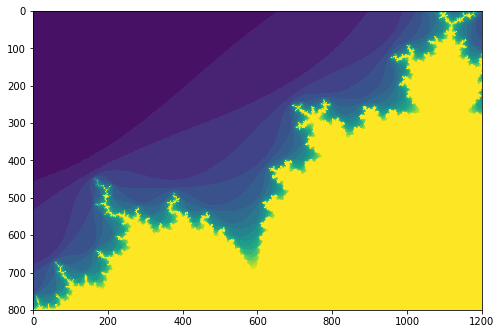

In [3]:
%matplotlib inline
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots(figsize=(10, 5.5))
ax.imshow(fractal);

In [6]:
# Numpy operates array-at-a-time, you have to completely rethink the "iterate until converged" part.

def run_numpy(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.full(c.shape, maxiterations, dtype=numpy.int32)
    z = c
    for i in range(maxiterations):
        z = z**2 + c                                            # applying z → z² + c
        diverged = numpy.absolute(z) > 2                        # |z| > 2 is "divergence"
        diverging_now = diverged & (fractal == maxiterations)   # some are already done
        fractal[diverging_now] = i                              # just set the new ones
        z[diverged] = 2                                         # clamp diverged at 2
    return fractal

starttime = time.time()
fractal = run_numpy(1600, 2400)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (1600 * 2400)))

368.3686877290408 ns per pixel


In [9]:
# But once it's in a Numpy-friendly form, it's ready for GPUs.
import cupy

def run_cupy(height, width, maxiterations=20):
    y, x = cupy.ogrid[-1:0:height*1j, -1.5:0:width*1j]               # <--- changed this line
    c = x + y*1j
    fractal = cupy.full(c.shape, maxiterations, dtype=numpy.int32)   # <--- changed this line
    z = c
    for i in range(maxiterations):
        z = z**2 + c                                            # applying z → z² + c
        diverged = numpy.absolute(z) > 2                        # |z| > 2 is "divergence"
        diverging_now = diverged & (fractal == maxiterations)   # some are already done
        fractal[diverging_now] = i                              # just set the new ones
        z[diverged] = 2                                         # clamp diverged at 2
    return fractal

starttime = time.time()
fractal = run_cupy(3200, 4800)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (3200 * 4800)))

80.9035108735164 ns per pixel


In [13]:
# Numba, on the other hand, lets you run the original Python code, but faster.
import numba

@numba.jit
def run_numba(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.full(c.shape, maxiterations, dtype=numpy.int32)
    for h in range(height):
        for w in range(width):                  # for each pixel (h, w)...
            z = c[h, w]
            for i in range(maxiterations):      # iterate at most 20 times
                z = z**2 + c[h, w]              # applying z → z² + c
                if abs(z) > 2:                  # if it diverges (|z| > 2)
                    fractal[h, w] = i           # color the plane with the iteration number
                    break                       # we're done, no need to keep iterating
    return fractal

starttime = time.time()
fractal = run_numba(6400, 9600)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (6400 * 9600)))

136.12230929235616 ns per pixel


In [19]:
# Numba also has an OpenMP-like, "parallel for" (prange) to parallelize without complex dependencies.
import numba

@numba.jit(parallel=True)
def run_numba_parallel(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.full(c.shape, maxiterations, dtype=numpy.int32)
    for h in numba.prange(height):
        for w in numba.prange(width):           # for each pixel (h, w)...
            z = c[h, w]
            for i in range(maxiterations):      # iterate at most 20 times
                z = z**2 + c[h, w]              # applying z → z² + c
                if abs(z) > 2:                  # if it diverges (|z| > 2)
                    fractal[h, w] = i           # color the plane with the iteration number
                    break                       # we're done, no need to keep iterating
    return fractal

starttime = time.time()
fractal = run_numba_parallel(6400, 9600)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (6400 * 9600)))

45.62521353363991 ns per pixel


In [22]:
# Numba can compile to GPUs, too, but you have to identify the kernel and set block sizes.
import numba.cuda, math
def run_numba_cuda(height, width, maxiterations=20):
    fractal = numpy.empty((height, width), dtype=numpy.int32)
    griddim = (math.ceil(height / 32), math.ceil(width / 32))
    blockdim = (32, 32)
    inner_loop_cuda[griddim, blockdim](height, width, maxiterations, fractal)
    return fractal
@numba.cuda.jit
def inner_loop_cuda(height, width, maxiterations, fractal):
    x, y = numba.cuda.grid(2)                   # 2-dimensional CUDA grid
    z = c = -1.5 + y*1.0/(height + 1) + -1j + x*1j*1.5/(width + 1)
    fractal[x, y] = maxiterations
    for i in range(maxiterations):      # iterate at most 20 times
        z = z**2 + c                    # applying z → z² + c
        if abs(z) > 2:                  # if it diverges (|z| > 2)
            fractal[x, y] = i           # color the plane with the iteration number
            break                       # we're done, no need to keep iterating
starttime = time.time()
fractal = run_numba_cuda(12800, 19200)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (12800 * 19200)))

7.887248648330569 ns per pixel


In [28]:
# Dask can keep all of your processors busy, but it might be making a more complex graph than you want.
import dask.array

def run_dask(height, width, maxiterations=20, hchunks=3, vchunks=4):
    chunked = lambda a: dask.array.from_array(a, chunks=(height // hchunks, width // vchunks))
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = chunked(x + y*1j)
    fractal = chunked(numpy.full(c.shape, maxiterations, dtype=numpy.int32))
    z = c
    for i in range(maxiterations):
        z = z**2 + c                                            # applying z → z² + c
        diverged = numpy.absolute(z) > 2                        # |z| > 2 is "divergence"
        diverging_now = diverged & (fractal == maxiterations)   # some are already done
        fractal[diverging_now] = i                              # just set the new ones
        z[diverged] = 2                                         # clamp diverged at 2
    return fractal

starttime = time.time()
fractal = run_dask(1600, 2400).compute()
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (1600 * 2400)))

238.11068385839462 ns per pixel


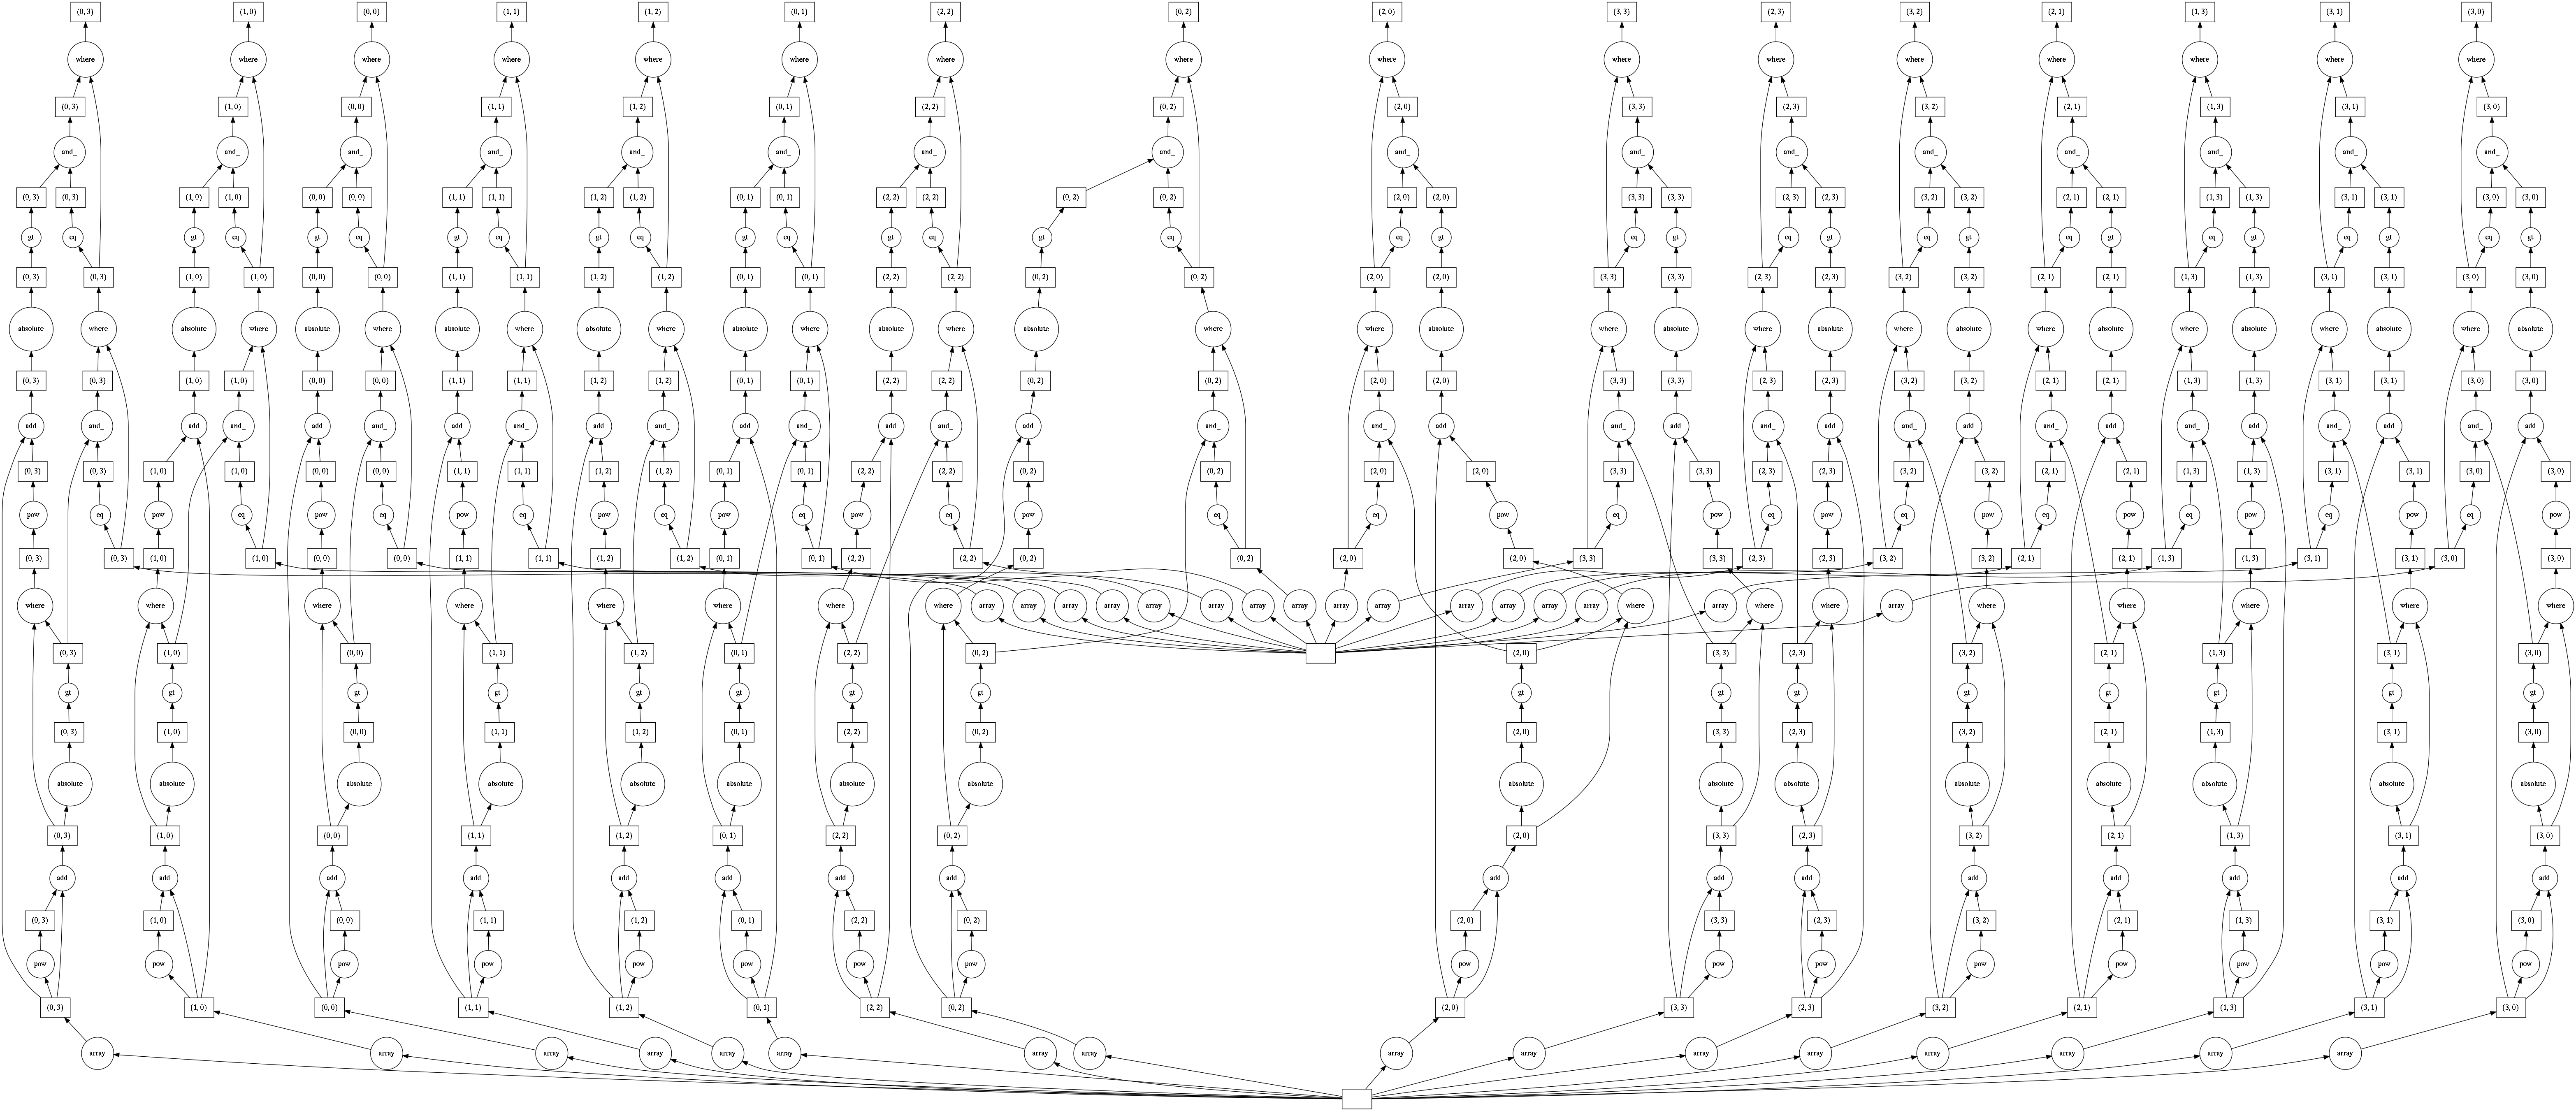

In [29]:
run_dask(1600, 2400, maxiterations=2, hchunks=3, vchunks=4).visualize()

In [30]:
# The problem is that the dependency graph is too complex.
# Simplify it by encapsulating all the work in a Numpy universal function.

@numba.vectorize([numba.int32(numba.complex128, numba.int32)])
def run_numba_ufunc(c, maxiterations):
    z = c
    for i in range(maxiterations):
        z = z**2 + c
        if abs(z) > 2:
            return i
    return maxiterations

def run_dask_numba(height, width, maxiterations=20, hchunks=3, vchunks=4):
    chunked = lambda a: dask.array.from_array(a, chunks=(height // hchunks, width // vchunks))
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    return run_numba_ufunc(chunked(x + y*1j), maxiterations)

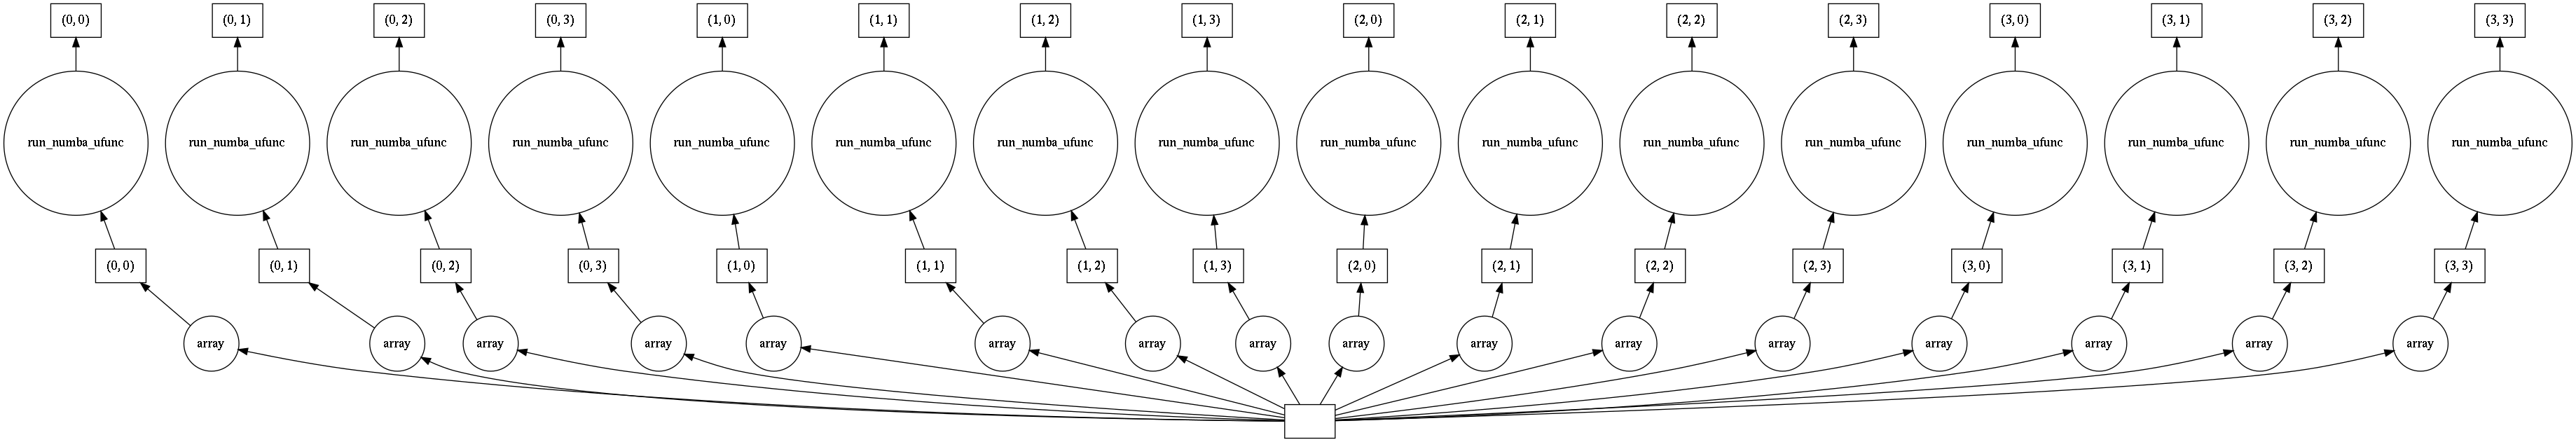

In [31]:
# Dask sees the Numpy universal function as a black box, minimizing tasks and dependencies.

run_dask_numba(1600, 2400, maxiterations=20, hchunks=3, vchunks=4).visualize()

In [34]:
starttime = time.time()
fractal = run_dask_numba(6400, 9600, hchunks=12, vchunks=16).compute()
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (6400 * 9600)))

47.581844652692475 ns per pixel


In [35]:
%load_ext Cython

# Cython is a language that mixes C++ and Python. Can it help?

In [36]:
%%cython --cplus -c-O3
import cython, numpy       # load Python interface to Numpy
cimport numpy              # load C++ interface to Numpy (types end in _t)

@cython.boundscheck(False) # turn off bounds-checking
@cython.wraparound(False)  # turn off negative index wrapping (e.g. -1 for last element)
def run_cython(int height, int width, int maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.zeros(c.shape, dtype=numpy.int32) + maxiterations
    cdef numpy.ndarray[numpy.complex128_t, ndim=2, mode="c"] c_array = c
    cdef numpy.ndarray[numpy.int32_t,      ndim=2, mode="c"] fractal_array = fractal
    cdef numpy.complex128_t z
    for h in range(height):
        for w in range(width):
            z = c_array[h, w]
            for i in range(maxiterations):
                z = z**2 + c_array[h, w]
                if z.real*z.real + z.imag*z.imag > 4:
                    fractal_array[h, w] = i
                    break
    return fractal

In [43]:
# Even with all the work we had to do, Cython's performance is underwhelming.

starttime = time.time()
fractal = run_cython(800, 1200)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (800 * 1200)))

1485.1080874602 ns per pixel


In [44]:
%%cython --cplus -c-O3
import cython, numpy       # load Python interface to Numpy
cimport numpy              # load C++ interface to Numpy (types end in _t)

cdef extern from *:
    """
#include <complex>
void inner_loop(int height, int width, int maxiterations, std::complex<double>* c, int* fractal) {
    for (int h = 0;  h < height;  h++) {
        for (int w = 0;  w < width;  w++) {
            std::complex<double> ci = c[h + height*w];
            std::complex<double> z = ci;
            for (int i = 0;  i < maxiterations;  i++) {
                z = z*z + ci;
                if (z.real()*z.real() + z.imag()*z.imag() > 4) {
                    fractal[h + height*w] = i;
                    break;
}}}}}
    """
    void inner_loop(int height, int width, int maxiterations, numpy.complex128_t* c, int* fractal)

@cython.boundscheck(False) # turn off bounds-checking
@cython.wraparound(False)  # turn off negative index wrapping (e.g. -1 for last element)
def run_cython_asdoor(int height, int width, int maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.zeros(c.shape, dtype=numpy.int32) + maxiterations
    inner_loop(height, width, maxiterations, <numpy.complex128_t*>(<size_t>c.ctypes.data), <int*>(<size_t>fractal.ctypes.data))
    return fractal

In [48]:
# Even with all the work we had to do, Cython's performance is underwhelming.

starttime = time.time()
fractal = run_cython_asdoor(3200, 4800)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (3200 * 4800)))

98.57779368758202 ns per pixel


In [49]:
%%writefile run_pybind11.cpp
#include <complex>
#include <pybind11/pybind11.h>    // pybind11: another (better) way to compile C++ for Python.
#include <pybind11/numpy.h>
namespace py = pybind11;
void run(int height, int width, int maxiterations,
         py::array_t<std::complex<double>> np_c, py::array_t<int> np_fractal) {
    std::complex<double>* c = static_cast<std::complex<double>*>(np_c.request().ptr);
    int* fractal = static_cast<int*>(np_fractal.request().ptr);
    for (int h = 0;  h < height;  h++) {
        for (int w = 0;  w < width;  w++) {
            std::complex<double> ci = c[h + height*w];
            std::complex<double> z = ci;
            for (int i = 0;  i < maxiterations;  i++) {
                z = z*z + ci;
                if (z.real()*z.real() + z.imag()*z.imag() > 4) {
                    fractal[h + height*w] = i;
                    break;
}}}}}
PYBIND11_MODULE(run_pybind11, m) {
    m.def("run", &run, "the inner loop");
}

Overwriting run_pybind11.cpp


In [50]:
%%bash

# Compile it as a Python extension module.

c++ -Wall -shared -std=c++11 -fPIC -O3                 \
    `python -m pybind11 --includes` run_pybind11.cpp   \
    -o run_pybind11`python3-config --extension-suffix`

In [53]:
import run_pybind11

starttime = time.time()
height, width, maxiterations = 3200, 4800, 20
y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
c = x + y*1j
fractal = numpy.full(c.shape, maxiterations, dtype=numpy.int32)
run_pybind11.run(height, width, maxiterations, c, fractal)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (3200 * 4800)))

97.54253551363945 ns per pixel


In [54]:
%%writefile run_pybind11_fastmath.cpp
#include <complex>
#include <pybind11/pybind11.h>    // We'll be compiling with -ffast-math (so we need a new name)!
#include <pybind11/numpy.h>
namespace py = pybind11;
void run(int height, int width, int maxiterations,
         py::array_t<std::complex<double>> np_c, py::array_t<int> np_fractal) {
    std::complex<double>* c = static_cast<std::complex<double>*>(np_c.request().ptr);
    int* fractal = static_cast<int*>(np_fractal.request().ptr);
    for (int h = 0;  h < height;  h++) {
        for (int w = 0;  w < width;  w++) {
            std::complex<double> ci = c[h + height*w];
            std::complex<double> z = ci;
            for (int i = 0;  i < maxiterations;  i++) {
                z = z*z + ci;
                if (z.real()*z.real() + z.imag()*z.imag() > 4) {
                    fractal[h + height*w] = i;
                    break;
}}}}}
PYBIND11_MODULE(run_pybind11_fastmath, m) {
    m.def("run", &run, "the inner loop");
}

Overwriting run_pybind11_fastmath.cpp


In [55]:
%%bash

# This time, compile with -ffast-math: trades floating point accuracy for speed.

c++ -Wall -shared -std=c++11 -fPIC -O3 -ffast-math              \
    `python -m pybind11 --includes` run_pybind11_fastmath.cpp   \
    -o run_pybind11_fastmath`python3-config --extension-suffix`

In [60]:
import run_pybind11_fastmath

starttime = time.time()
height, width, maxiterations = 3200, 4800, 20
y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
c = x + y*1j
fractal = numpy.full(c.shape, maxiterations, dtype=numpy.int32)
run_pybind11_fastmath.run(height, width, maxiterations, c, fractal)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (3200 * 4800)))

69.7964026282231 ns per pixel


In [63]:
import ROOT

# With ROOT, it's much easier to mingle C++ in Python

ROOT.gInterpreter.Declare("""
void run_root_2(int height, int width, int maxiterations, double* c2, int* fractal) {
    auto c = reinterpret_cast<std::complex<double>*>(c2);
    for (int h = 0;  h < height;  h++) {
        for (int w = 0;  w < width;  w++) {
            std::complex<double> ci = c[h + height*w];
            std::complex<double> z = ci;
            for (int i = 0;  i < maxiterations;  i++) {
                z = z*z + ci;
                if (z.real()*z.real() + z.imag()*z.imag() > 4) {
                    fractal[h + height*w] = i;
                    break;
}}}}}
""")

starttime = time.time()
height, width, maxiterations = 3200, 4800, 20
y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
c = x + y*1j
fractal = numpy.full(c.shape, maxiterations, dtype=numpy.int32)
ROOT.run_root_2(height, width, maxiterations, c.view(numpy.float64).reshape(-1), fractal.reshape(-1))
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (3200 * 4800)))

379.12876966098946 ns per pixel


### Summary

The times measured above are collected here.

| Method                                     | time (ns/px) | speedup |
|:-------------------------------------------|-------------:|--------:|
| Pure Python                                       | 12000   |    1× |
| Vectorized Numpy                                  |   368   |   30× |
| Vectorized CuPy (run on GPU)                      |    81   |  150× |
| Compiled by Numba                                 |   136   |   90× |
| Compiled & parallelized by Numba                  |    45   |  250× |
| Compiled & run on GPU by Numba                    |     7.8 | 1500× |
| Parallelized by Dask                              |   238   |   50× |
| Parallelized by Dask, compiled by Numba           |    48   |  250× |
| Partially rewritten in Cython (Python/C++ hybrid) |  1485   |    8× |
| Completely rewritten in Cython (door to C++)      |    99   |  120× |
| Completely rewritten in pybind11 (pure C++)       |    98   |  120× |
| Completely rewritten in ROOT (pure C++)           |   379   |   32× |

The number of cores qualifies the speedup, and GPU methods rely on special hardware. Perfect scaling was never observed; independent, pinned, single-core processes could possibly do better.